In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate
import param
import panel as pn
import panel.widgets as pnw
from bokeh.resources import INLINE
import warnings

warnings.filterwarnings('ignore')
np.seterr(all='ignore')
pn.extension()
%matplotlib inline

In [2]:
def dco_merger_tab():
    '''function to plot merger time for different values of compact object masses'''

    m1 = pnw.IntSlider(name='primary compact-object mass', value=30, start=2, end=40, step=2)
    m2 = pnw.IntSlider(name='secondary compact-object mass', value=8, start=2, end=40, step=2)
    
    def merger_time(m1, m2, a, e):
        '''merger time for a DCO with initial binary params: m1, m2, a, e.
        See Peters (1964) for derivation'''
        standard_cgrav = 6.67428e-8; clight = 2.99792458e10
        Msun = 1.9892e33; Rsun = 6.9598e10
        secyer = 3.1558149984e7; Gyr = 1e9

        m1 = m1 * Msun; m2 = m2 * Msun
        a = a * Rsun
        beta = 12.8e0 * np.power(standard_cgrav,3) * m1 * m2 * (m1 + m2) / np.power(clight,5)

        if abs(e - 0e0) < 1e-6:
            return np.power(a,4) / (4*beta) / secyer / Gyr  # in Gyr
        else:
            integ = lambda x: np.power(x,1.526315789e0) * \
                np.power((1e0 + 0.3980263158e0 * np.power(x,2)), 0.5137016094e0) \
                / np.power(1e0-np.power(x,2),1.5e0)
            I, err = integrate.quadrature(integ, 0, e, tol=1.49e-8)
            c0 = a * (1e0 - np.power(e,2)) * np.power(e,-0.6315789474e0)
            c0 = c0 * np.power(1e0 + 0.3980263158e0 * np.power(e,2),-0.3784254023e0)
            return (0.6315789474 * np.power(c0,4) * I / beta) / secyer / Gyr

    @pn.depends(m1, m2)
    def get_as(m1, m2):
        ecc = np.linspace(0,0.999,50)
        a_100myr, a_1gyr, a_hubble = np.zeros(len(ecc)), np.zeros(len(ecc)), np.zeros(len(ecc))
        for k,e in enumerate(ecc):
            h1 = lambda a: merger_time(m1, m2, a, e) - 13.64
            a_hubble[k] = optimize.bisect(h1, 0, 1e6, maxiter=100)

        plt.style.use('style.mpl')
        fig2, ax = plt.subplots()
        ax.set_xscale('log')
        ax.set_xlim(left=7, right=200)
        ax.set_ylim(bottom=0, top=1)
        ax.set_xlabel('binary separation (R$_\odot$)')
        ax.set_ylabel('eccentricity')

        # constant merger time lines
        ax.plot(a_hubble, ecc, color='black', label='Hubble time')
        ax.legend(loc=3, frameon=True, fancybox=True, fontsize=16,
                facecolor='lightgray', edgecolor='dimgray')

        ax.fill_between(np.linspace(0.1,np.min(a_hubble)), 0, 1, color='C0')
        ax.fill_between(a_hubble, ecc, 1, color='C0')

        # texts
        # - info on GW event
        ax.annotate('CO masses\n {} {} {}\n {} {} {}'.format(
            r'$m_1 =$', m1, r'M$_\odot$', r'$m_2 =$', m2, r'M$_\odot$'), xy=(50,0.32),
            bbox=dict(facecolor='lightgray', edgecolor='dimgray', boxstyle='round, pad=0.4'))
        # - allowed region
        ax.annotate('Allowed region', xy=(9.0,0.85), rotation=0, color='white', fontsize=20)
        plt.tight_layout()
        plt.close()
        return fig2

    return pn.Column(m1, m2), get_as

In [3]:
header = pn.pane.Markdown('''
# Merger times of double compact object systems
''', margin=(0, 0, 10, 0))

h2 = pn.pane.Markdown('''
Timescale for the merger due to gravitational wave emission (Peters 1964)
''', margin=(0, 0, 10, 0))

latex = pn.pane.LaTeX(r'''
$\begin{aligned}
  t_\mathrm{merger} & = \dfrac{15}{304} \dfrac{a_{0}^{4} c^{5}}{G^{3} m_{1} m_{2} (m_{1} + m_{2})} \times \left[\left(1+e_{0}^{2}\right) e_{0}^{-12/19} \left(1 + \dfrac{121}{304} e_{0}^{2} \right)^{-870/2299}\right]^{4} \times \int_{0}^{e_{0}} f(e) \mathrm{d}e
\end{aligned}$
''', style={'font-size': '10pt'}, margin=(0, 0, 10, 0))

latex2 = pn.pane.LaTeX(r'''
where we define,

$\begin{aligned}
 f(e) & = \dfrac{e^{29/19} \left[1+\left(121/304\right)e^{2}\right]^{1181/2299}}{\left(1-e^{2}\right)^{3/2}}
\end{aligned}$''', style={'font-size': '10pt'}, margin=(0, 0, 10, 0))

h3 = pn.pane.Markdown('''
### Separation and eccentricity values for having merger times below the age of the Universe

Here, we can see which range of binary parameters are allowed for a given set of compact-object
masses to merge within the Hubble time (light-blue region in the figure). The black line
represents the Hubble time.
''', margin=(10, 0, 0, 0))

column, fig = dco_merger_tab()

dashboard = pn.Column(header,
                      h2,
                      latex,
                      latex2,
                      pn.Row(pn.Column(h3, column), fig),
                      margin=(0, 0, 0, 10), sizing_mode='stretch_width')  # .show(title='Progenitors of gravitational waves')


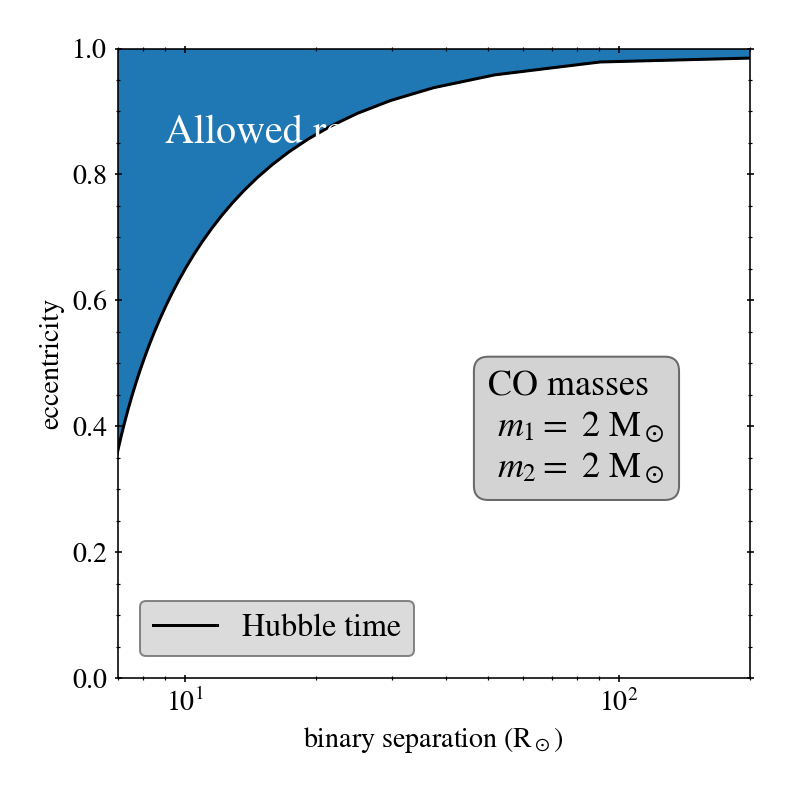
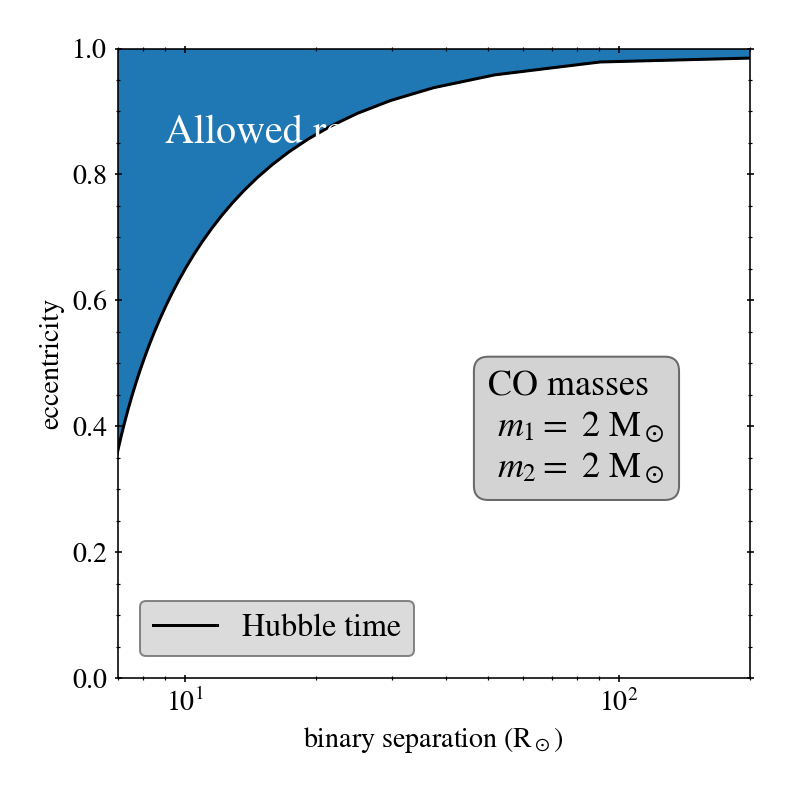
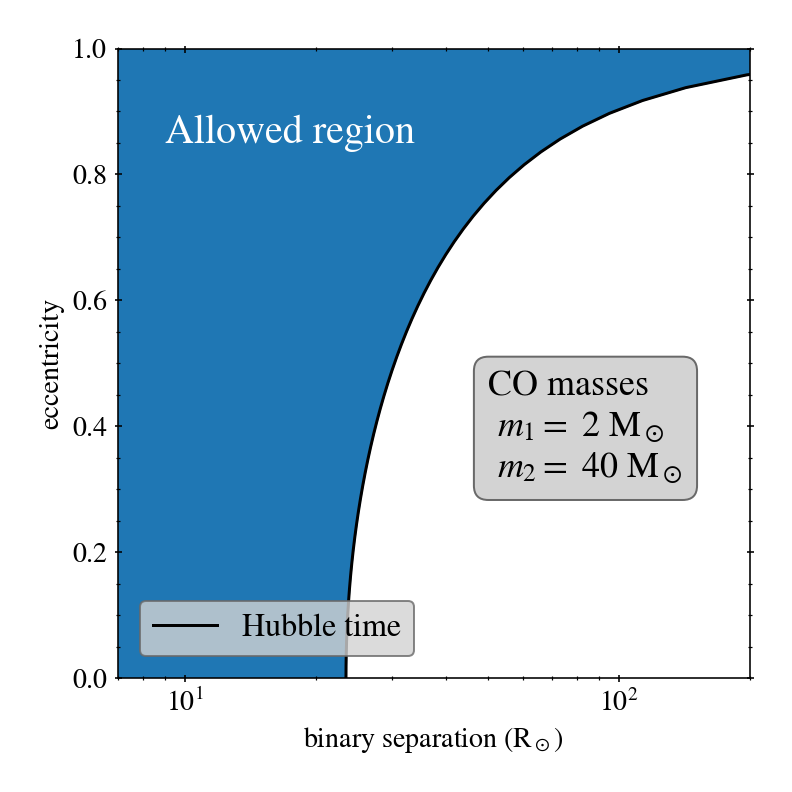
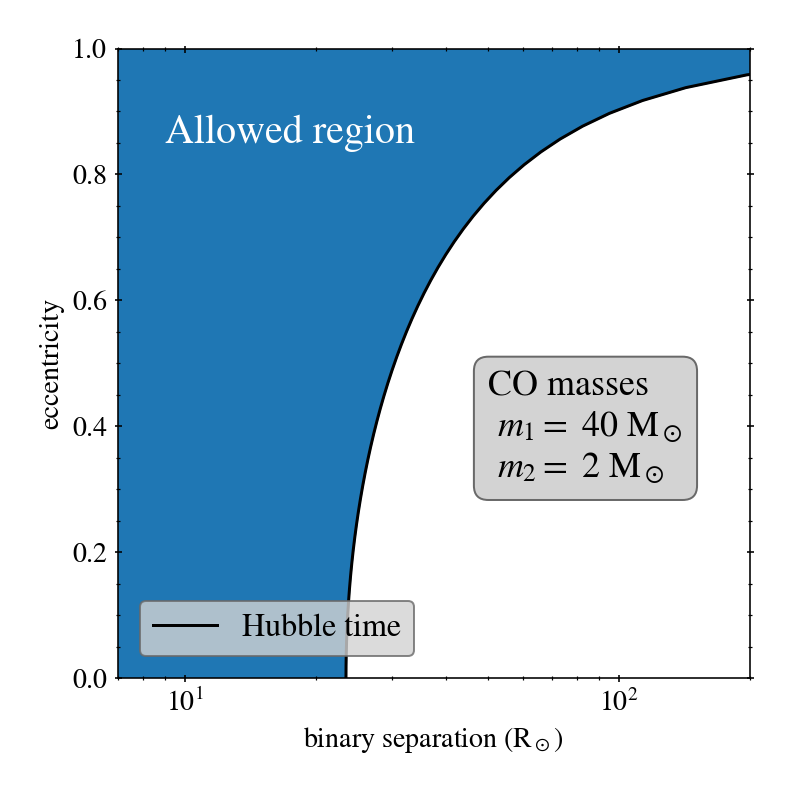
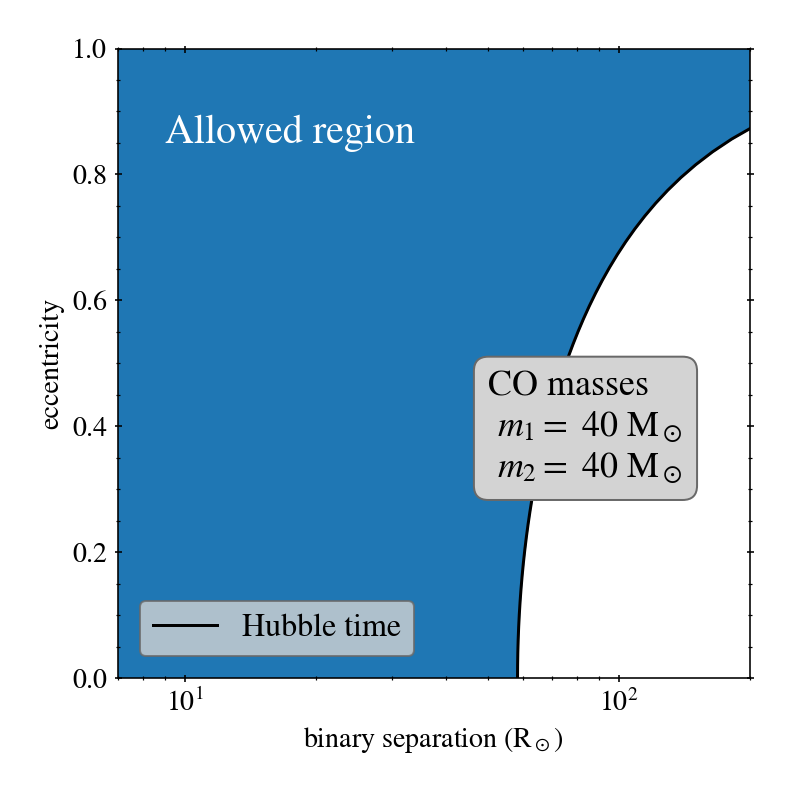

In [4]:
# for testing purposes, use just two cases
dashboard.embed(max_opts=2)

# to have many more primary/secondary masses display, uncomment
# dashboard.embed(max_opts=14)